In [1]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
import optuna

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Filepaths
dataPath = '/content/drive/MyDrive/Colab Notebooks/DRW/data/'
fileName = 'train.parquet'

In [ ]:
# Read train data
df_train = pd.read_parquet(dataPath + fileName)
df_train = df_train.loc[:, ~(df_train == -np.inf).any()]

In [ ]:
# Features and label split
exclude_cols = ('bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume')
features = [col for col in df_train.columns if col not in exclude_cols and col != 'label']

In [ ]:
# Functions to calculate pearson correlation for the whole dataset and for a window respectively
def compute_correlation(feature):
  r, p = pearsonr(df_train[feature], df_train['label'])
  return feature, r, p

def compute_correlation_in_window(df_window, feature):
  r, p = pearsonr(df_window[feature], df_window['label'])
  return feature, r, p

In [ ]:
# Standardize features
scaler = StandardScaler()
for col in features:
  C = scaler.fit_transform(df_train[col].values.reshape(-1, 1))
  df_train[col] = C

In [ ]:
# Calculate pearson correlation for each pair of label and X_
results = Parallel(n_jobs=-1)(delayed(compute_correlation)(feature) for feature in features)

In [ ]:
# Find results with significant p values as p <= 0.05
significantRes = []
for val in results:
  if val[2]<=0.05:
    significantRes.append(val)

In [ ]:
# Create 5 day groups so that we can calculate pearson correlation in windows
grouped = df_train.groupby(pd.Grouper(freq = '5D'))

In [ ]:
# Calculate pearson correlation for each pair within all groups
resultsWin = []
for period_start, df_window in grouped:
  output = output = Parallel(n_jobs=-1)(
        delayed(compute_correlation_in_window)(df_window, feature) for feature in features)

  # Append results
  for feature, r, p in output:
        resultsWin.append({
            'period_start': period_start,
            'feature': feature,
            'correlation': r,
            'p_value': p
        })

In [ ]:
correlation_df = pd.DataFrame(resultsWin)

In [ ]:
# for X in list(correlation_df['feature'].unique()):
#   singleX = correlation_df[correlation_df['feature'] == X]
#   plt.plot(singleX['period_start'], singleX['p_value'])
#   plt.title(X)
#   plt.show()

In [ ]:
# for X in list(correlation_df['feature'].unique()):
#   singleX = correlation_df[correlation_df['feature'] == X]
#   plt.plot(singleX['period_start'], singleX['correlation'])
#   plt.title(X)
#   plt.show()

In [ ]:
stdX = []
for X in list(correlation_df['feature'].unique()):
  stdP = correlation_df[correlation_df['feature'] == X]['p_value'].std()
  stdX.append((X, stdP))

In [ ]:
stdXdf = pd.DataFrame(stdX, columns = ['feature', 'std']).sort_values(by = 'std', ascending = True)

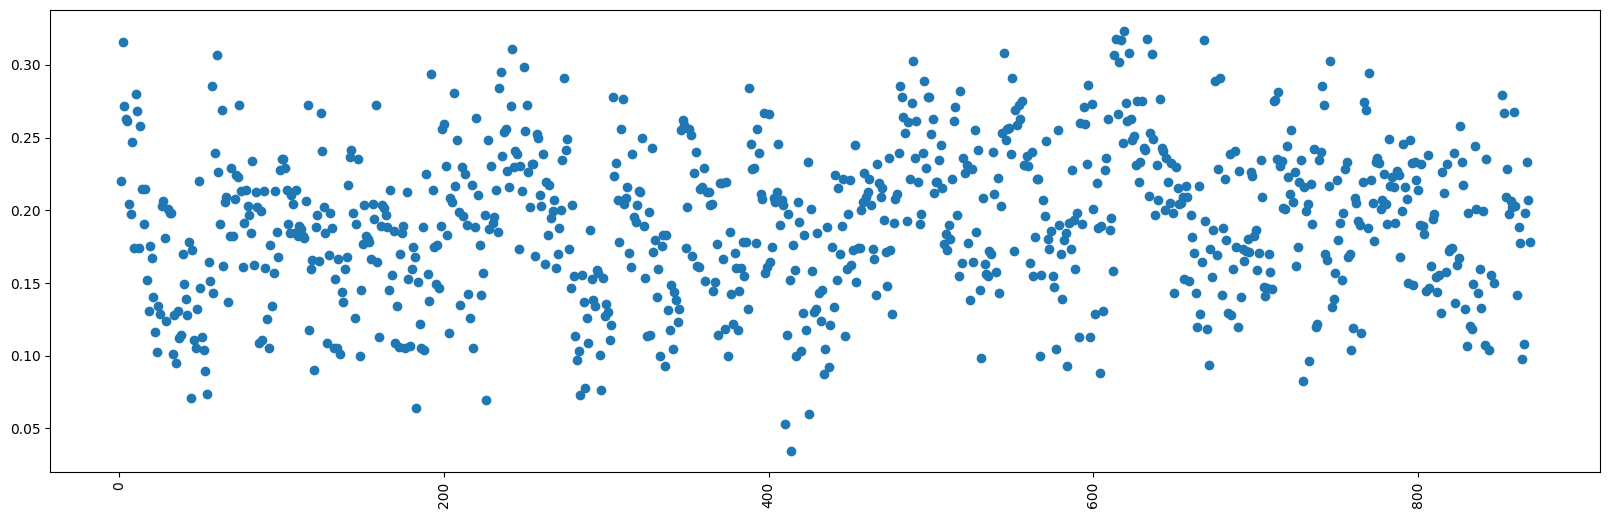

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(stdXdf.index + 1, stdXdf['std'])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
display(max(stdXdf['std']))

0.32328557418683584

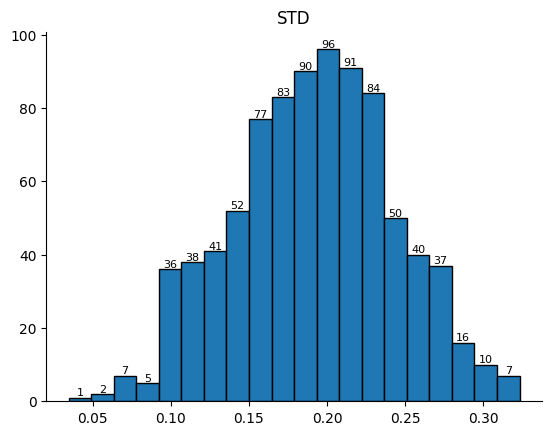

In [ ]:
data = stdXdf['std']

# Create the histogram manually to get counts and bins
counts, bins, patches = plt.hist(data, bins=20, edgecolor='black')

# Annotate the bars with the count above each bar
for count, bin_edge, patch in zip(counts, bins, patches):
    if count > 0:
        plt.text(
            x=patch.get_x() + patch.get_width() / 2,
            y=count,
            s=str(int(count)),
            ha='center',
            va='bottom',
            fontsize=8
        )

# Set title and remove top/right spines
plt.title('STD')
plt.gca().spines[['top', 'right']].set_visible(False)

plt.show()

In [ ]:
stdXdf = stdXdf.sort_values(by = 'std', ascending = True).reset_index(drop = True)

In [ ]:
group1 = list(stdXdf['feature'].loc[:15])
group2 = list(stdXdf['feature'].loc[16:183])
group3 = list(stdXdf['feature'].loc[184:529])
group4 = list(stdXdf['feature'].loc[530:704])
group5 = list(stdXdf['feature'].loc[705:832])
group6 = list(stdXdf['feature'].loc[833:])
groups = [group1, group2, group3, group4, group5, group6]

In [ ]:
i_pca = [3, 3, 3, 3, 5, 3]
df_pca_list = []

for idx, (group, n_comp) in enumerate(zip(groups, i_pca), start=1):
    pca = PCA(n_components=n_comp)
    pca_result = pca.fit_transform(df_train[group])

    # Create column names like G1P1, G1P2, ...
    col_names = [f"G{idx}P{j+1}" for j in range(n_comp)]
    df_pca_group = pd.DataFrame(pca_result, columns=col_names, index=df_train.index)

    df_pca_list.append(df_pca_group)

# Concatenate all PCA results horizontally
X = pd.concat(df_pca_list, axis=1)

In [ ]:
Y = pd.DataFrame(df_train['label'])

In [ ]:
def lag_features_only(features_df, lags=5):
    lagged = pd.DataFrame(index=features_df.index)

    for col in features_df.columns:
        for lag in range(1, lags + 1):
            lagged[f"{col}_lag{lag}"] = features_df[col].shift(lag)

    return lagged.dropna()

In [ ]:
X_lagged = lag_features_only(X)

# Shift the label to align it with lagged features: we predict label[t] using X[t-1], X[t-2], ...
y_aligned = Y.loc[X_lagged.index, 'label']

In [ ]:
X = X_lagged
y = y_aligned

In [ ]:
# Hyperparameter tuning objective
def objective(trial):
    # Sample hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42,
        "n_jobs": -1,
    }

    model = XGBRegressor(**params)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    correlations = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        # Pearson correlation
        corr, _ = pearsonr(y_val, preds)
        correlations.append(corr)

    # Return average correlation across folds (maximize)
    return np.mean(correlations)

In [ ]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best result
print("Best trial:")
print(f"  Pearson correlation: {study.best_value:.4f}")
print("  Hyperparameters:")
for key, val in study.best_params.items():
    print(f"    {key}: {val}")

[I 2025-05-26 19:50:11,032] A new study created in memory with name: no-name-7f5a5c2e-af29-4bca-886b-9762f855e0a4
[I 2025-05-26 19:50:47,785] Trial 0 finished with value: 0.04323154821685587 and parameters: {'n_estimators': 98, 'max_depth': 8, 'learning_rate': 0.07858393425289247, 'subsample': 0.8158301287600038, 'colsample_bytree': 0.9652987114024276, 'gamma': 0.8615301108852219, 'reg_alpha': 0.36477001670730425, 'reg_lambda': 2.7636555395165368}. Best is trial 0 with value: 0.04323154821685587.
[I 2025-05-26 19:51:16,060] Trial 1 finished with value: 0.04704009132838889 and parameters: {'n_estimators': 167, 'max_depth': 6, 'learning_rate': 0.16538106426084062, 'subsample': 0.5459465487856414, 'colsample_bytree': 0.8369090973544032, 'gamma': 2.4752049387433663, 'reg_alpha': 3.148736589935583, 'reg_lambda': 0.3730464526142979}. Best is trial 1 with value: 0.04704009132838889.
[I 2025-05-26 19:52:08,788] Trial 2 finished with value: 0.035531847145463716 and parameters: {'n_estimators': 

Best trial:
  Pearson correlation: 0.0561
  Hyperparameters:
    n_estimators: 246
    max_depth: 2
    learning_rate: 0.11062175627157103
    subsample: 0.5362681853215812
    colsample_bytree: 0.682300342902177
    gamma: 2.2548912780262933
    reg_alpha: 4.1204191807715445
    reg_lambda: 4.6282672258612845


In [ ]:
print(study.best_params.items())

dict_items([('n_estimators', 246), ('max_depth', 2), ('learning_rate', 0.11062175627157103), ('subsample', 0.5362681853215812), ('colsample_bytree', 0.682300342902177), ('gamma', 2.2548912780262933), ('reg_alpha', 4.1204191807715445), ('reg_lambda', 4.6282672258612845)])


In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [ ]:
best_params = study.best_params.copy()

best_params.update({
    "random_state": 42,
    "n_jobs": -1,
})

In [ ]:
# best_params = {'n_estimators': 246,
#  'max_depth': 2,
#  'learning_rate': 0.11062175627157103,
#  'subsample': 0.5362681853215812,
#  'colsample_bytree': 0.682300342902177,
#  'gamma': 2.2548912780262933,
#  'reg_alpha': 4.1204191807715445,
#  'reg_lambda': 4.6282672258612845,
#  'random_state': 42,
#  'n_jobs': -1}

In [ ]:
# Initialize final model
final_model = XGBRegressor(**best_params)

# Fit on the entire dataset
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.682300342902177, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.2548912780262933,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11062175627157103,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=246, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
import joblib
joblib.dump(final_model, dataPath + "final_xgboost_model.pkl")

['/content/drive/MyDrive/Colab Notebooks/DRW/data/final_xgboost_model.pkl']

In [ ]:
import json
from pathlib import Path

PATH = Path(dataPath)  # if it's not already

# Create full path by appending the file name
file_path = PATH / "groups.json"

# Save the data to JSON
with open(file_path, "w") as f:
    json.dump(groups, f, indent=2)